<br/>

$$ \huge{\underline{\textbf{ ANN and Correlated Data }}} $$

<a href="https://github.com/marcinbogdanski/ai_sketchpad"><- index</a>

<br/>


This is a super quick post to demostrate what happens when we feed correlated data into an artificial neural network. This is specially relevant when doing **reinforcement learning**. As agent traverses environment, **subsequent states are highly correlated**, i.e. what agent sees at time step t=100 is usually very similar to t=101, t=102 and so on.

We will also show a sneek peek on how **memory reply** fixes the issue.

Content:
* [Mini ANN](#Mini-ANN)
* [Test ANN with correlated data](Test-ANN-with-correlated-data)
* [Add pseudo memory reply](Add-pseudo-memory-reply)

# Mini ANN

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ANN_Correlated_Data import ANNFuncApprox

Minimal implementation of ANN using only numpy. You can check the full source [here](ANN_Correlated_Data.py)
* two layers only
  * sigmoid hidden layer
  * linear (no activation) output layer
  
Create neural net like so

In [2]:
ann = ANNFuncApprox(learn_rate=0.1, x_min=-100, x_max=100, nb_in=1, nb_hid=3, nb_out=1)

where **x_min** and **x_max** define input range (inputs are scaled internally to 0..1) and **nb_in**, **nb_hid** and **nb_out** are number of inputs, hidden units and outputs respectively.

Usage is quite simple as well, you can feed in one data point at a time, or in batches

In [3]:
print('eval at x=5')
print(ann.eval(5))
print()
print('batch eval at [1,2,3]')
print(ann.eval(np.array([[1],[2],[3]])))
print()

for i in range(1000):
    ann.train(5, 3)
    
print('eval at x=5 after training')
print(ann.eval(5))

eval at x=5
[[0.16561107]]

batch eval at [1,2,3]
[[0.17600689]
 [0.17338864]
 [0.17078323]]

eval at x=5 after training
[[3.]]


# Test ANN with correlated data

Let's create some data to work with - this is going to be the most boring data set ever
* **x** is going to be input, range -100 ... 100, step 0.1
* **y** is target to learn - just re-scaled x

In [4]:
x = np.arange(-100, 100, 0.1)
x_T = np.array(x, ndmin=2).T       # x_T as vertical vector, required by ANN batch mode
y = x / 100                        # learn stright line, should be easy

And let's create a neural network
* one input neuron - x is scalar
* 3 hidden neurons - we are learning to approximate stright line so this should be plenty enough
* one output neuron - y is also scalar

Note that I have picked hyper-parameters to exaggerate the effect for educational purposes.

In [5]:
ann = ANNFuncApprox(learn_rate=0.1, x_min=-100, x_max=100, nb_in=1, nb_hid=3, nb_out=1)

Plot untrained neural net

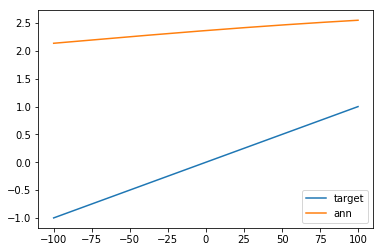

In [6]:
plt.plot(x, y, label='target')
plt.plot(x, ann.eval(x_T), label='ann')
plt.legend();

Let's feed correlated data into the neural net. We will traverse data set from left (-100) to right (100) one data point at a time and feed that single data point into neural net. This is more or less what would happen if we were training RL agent using e.g. TD learning.

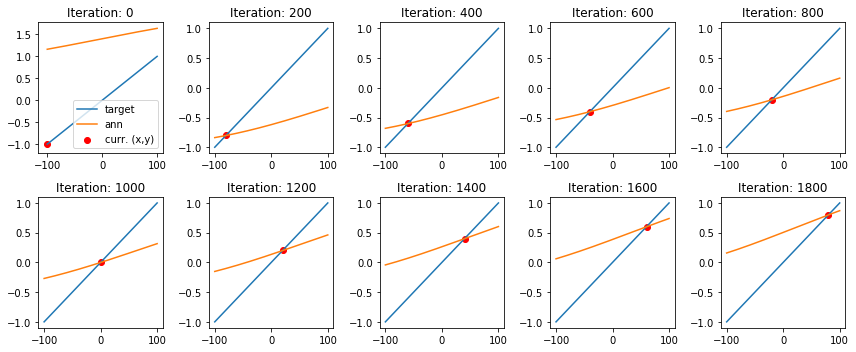

In [7]:
fig = plt.figure(figsize=[12,5])

for i in range(len(x)):       # move from left to right
    ann.train(x[i], y[i])     # feed one sample at a time
    
    if i % 200 == 0:
        ax = fig.add_subplot(2,5,i//200+1)
        ax.plot(x, y, label='target')
        ax.plot(x, ann.eval(x_T), label='ann')
        ax.scatter(x[i], y[i], color='red', label='curr. (x,y)')
        ax.set_title('Iteration: '+str(i))
        if i == 0:
            ax.legend();

plt.tight_layout()
plt.show()

Looding at the plots:
* iteration 0 - untrained neural net
* iteration 200 - by this point neural net correctly learned red data point
* iteration 400 - but as we keep moving right, neural net "cares" only about current data point!
* iteratios 600 oward - this is clearly not working

# Add pseudo memory reply

Let's try this again, reset the neural net

In [8]:
ann = ANNFuncApprox(learn_rate=0.1, x_min=-100, x_max=100, nb_in=1, nb_hid=3, nb_out=1)

As before agent will traverse data set from left to right, but this time we train ANN with random point from data points seen so far.

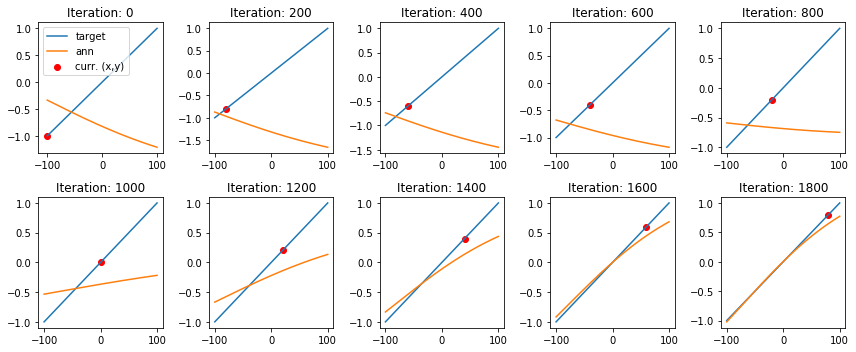

In [9]:
fig = plt.figure(figsize=[12,5])

for i in range(len(x)): 
    
    k = np.random.randint(0, i+1)   # <- THIS CHANGED: pick random data point from the past
    ann.train(x[k], y[k])
    
    if i % 200 == 0:
        ax = fig.add_subplot(2,5,i//200+1)
        ax.plot(x, y, label='target')
        ax.plot(x, ann.eval(x_T), label='ann')
        ax.scatter(x[i], y[i], color='red', label='curr. (x,y)')
        ax.set_title('Iteration: '+str(i))
        if i == 0:
            ax.legend();

plt.tight_layout()
plt.show()

As you can see, even though we used exactly the same number of points to train neural net, now it clearly doesn't forget the past and tries to fit the whole data set.